In [1]:
# add src to the sys path of this notebook
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent / "src"))

import data.load_data as ld
from data.preprocess_data import preprocess_logs_old, get_label_timeseries, downsample, filter
from models.helpers import create_model_params
import data.paths as config
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# Paper Experiments
Let's have a look at the data from the paper : https://doi.org/10.1002/rcs.70109

The data consists of logs with a timestamps column and different metrics our main interest is in the force sensor!

In [4]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = ld.get_paper_logs()
log_names.reset_index(drop=True, inplace=True)
logs = ld.load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from paper experiments.")

Loaded 206 logs from paper experiments.


In [5]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 103 logs with direction Backwards and 103 logs with direction Forwards.


## Markers
We have a marker file for each log with the timestamps of the start and end times representing the start and end of the clot.

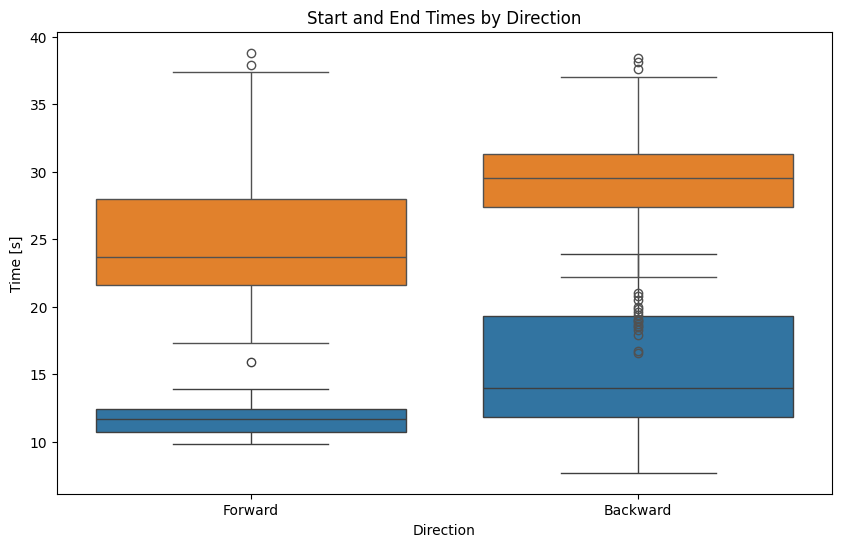

In [6]:
labels = ld.load_labels(log_names)

all_labels = pd.DataFrame()

for i, label in enumerate(labels):
    direction = log_names.loc[i, 'direction']

    # Add direction
    label['Direction'] = direction

    # Original times
    label['Start_orig'] = label['Start']
    label['End_orig'] = label['End']

    # Corrected times based on direction
    if direction == 'Backward':
        label['Start_corr'] = label['End']
        label['End_corr'] = label['Start']
    else:
        label['Start_corr'] = label['Start']
        label['End_corr'] = label['End']

    label['log_index'] = i

    all_labels = pd.concat([all_labels, label], ignore_index=True)

# ----------------------------------------------------
# Plot corrected start/end with direction labeling
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='Direction', y='Start_corr', data=all_labels)
sns.boxplot(x='Direction', y='End_corr', data=all_labels)

plt.title('Start and End Times by Direction')
plt.ylabel('Time [s]')
plt.show()


### Baseline Accuracy

We see here that the forward start time seems to be quite precise while all others will probably be more difficult to distinguish with a greater variation

In [7]:
# If I define accuray as being +- 1.5s from the actual start and end times, how accurate am I if I alwax predict mean start and end times?
tolerance = 1.5
for direction in ['Forward', 'Backward']:
    dir_labels = all_labels[log_names.loc[all_labels['log_index'], 'direction'] == direction]
    mean_start = dir_labels['Start'].mean()
    mean_end = dir_labels['End'].mean()
    accurate_starts = sum((dir_labels['Start'] >= mean_start - tolerance) & (dir_labels['Start'] <= mean_start + tolerance))
    accurate_ends = sum((dir_labels['End'] >= mean_end - tolerance) & (dir_labels['End'] <= mean_end + tolerance))
    total_labels = len(dir_labels)
    print(f"Direction: {direction}")
    print(f"  Accuracy for Start times: {accurate_starts}/{total_labels} ({accurate_starts/total_labels*100:.2f}%)")
    print(f"  Accuracy for End times: {accurate_ends}/{total_labels} ({accurate_ends/total_labels*100:.2f}%)")

Direction: Forward
  Accuracy for Start times: 87/103 (84.47%)
  Accuracy for End times: 16/103 (15.53%)
Direction: Backward
  Accuracy for Start times: 35/103 (33.98%)
  Accuracy for End times: 14/103 (13.59%)


### Length and Weights

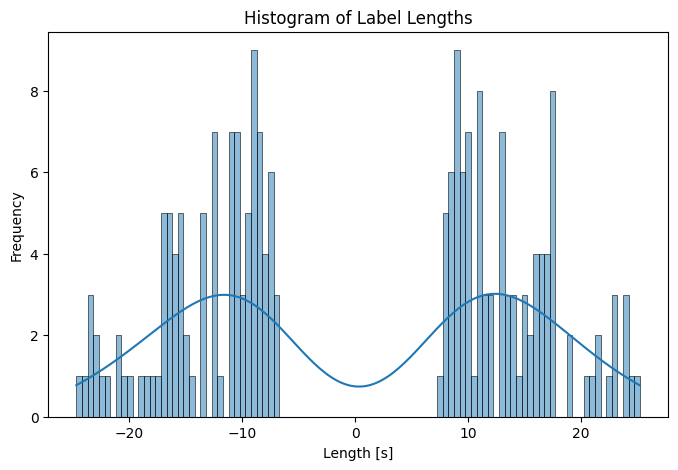

In [8]:
# histogram of length define as end - start
all_labels['Length'] = all_labels['End'] - all_labels['Start']
plt.figure(figsize=(8, 5))
sns.histplot(all_labels['Length'], bins=100, kde=True)
plt.title('Histogram of Label Lengths')
plt.xlabel('Length [s]')
plt.ylabel('Frequency')
plt.show()  

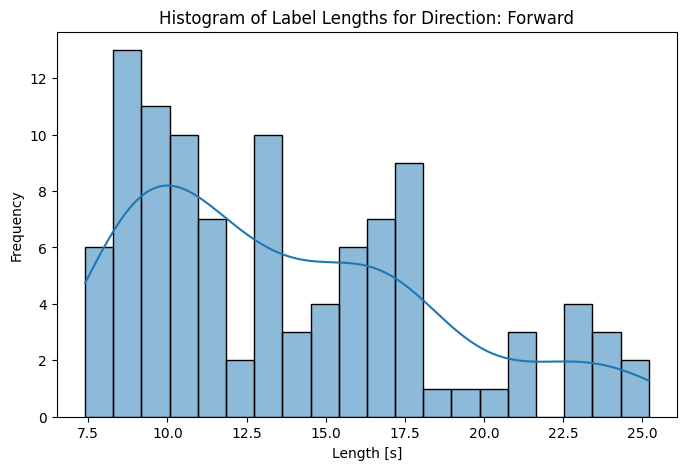

Direction: Forward, Peak Length: 9.96 s


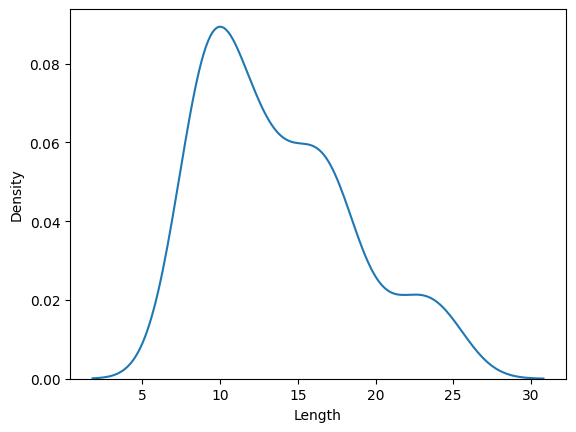

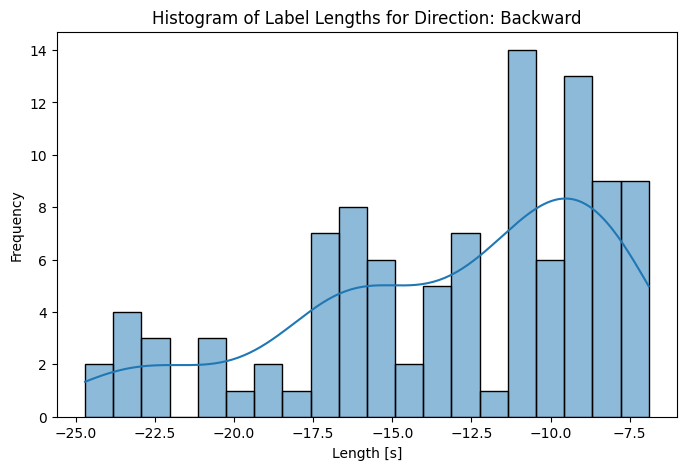

Direction: Backward, Peak Length: -9.55 s


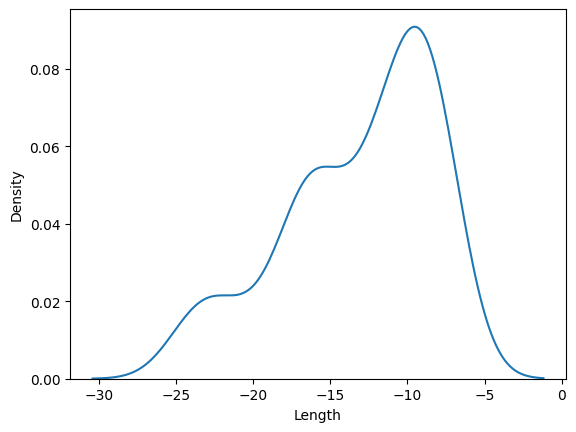

In [9]:
# histogram of length define as end - start
for direction in ['Forward', 'Backward']:
    dir_labels = all_labels[log_names.loc[all_labels['log_index'], 'direction'] == direction]
    plt.figure(figsize=(8, 5))
    sns.histplot(dir_labels['Length'], bins=20, kde=True)
    plt.title(f'Histogram of Label Lengths for Direction: {direction}')
    plt.xlabel('Length [s]')
    plt.ylabel('Frequency')
    plt.show()
    # get kde function
    kde = sns.kdeplot(dir_labels['Length'], bw_adjust=1).get_lines()[0].get_data()
    # find peak of kde
    peak_index = np.argmax(kde[1])
    peak_length = kde[0][peak_index]
    print(f"Direction: {direction}, Peak Length: {peak_length:.2f} s")

Direction: Forward, Peak Length (KDE): 10.12 s


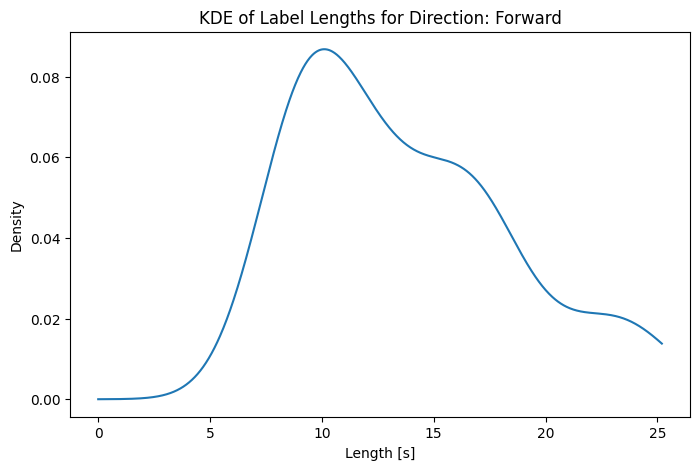

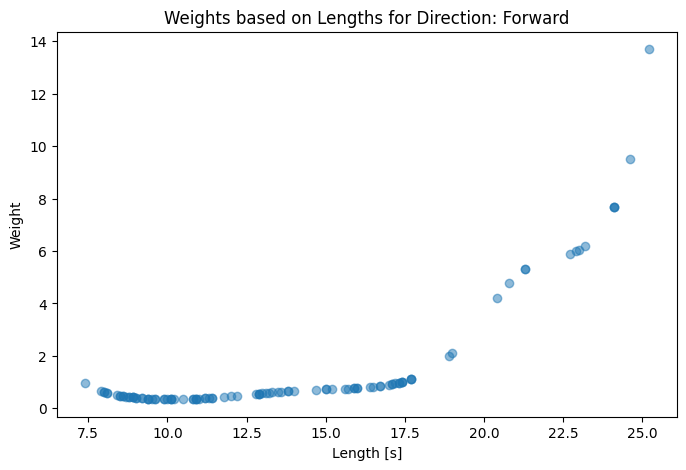

Direction: Backward, Peak Length (KDE): -6.90 s


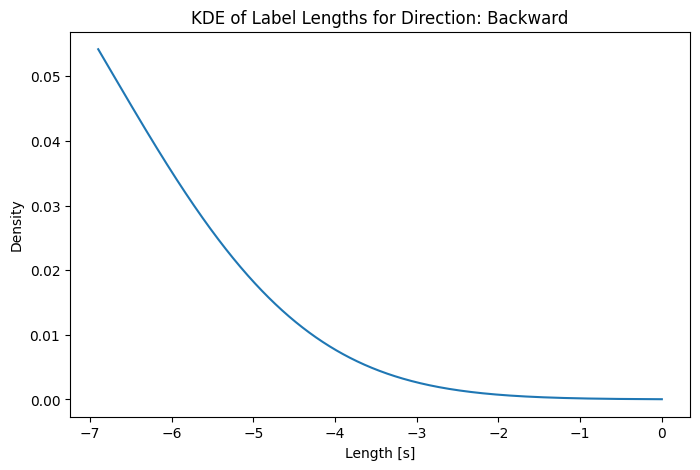

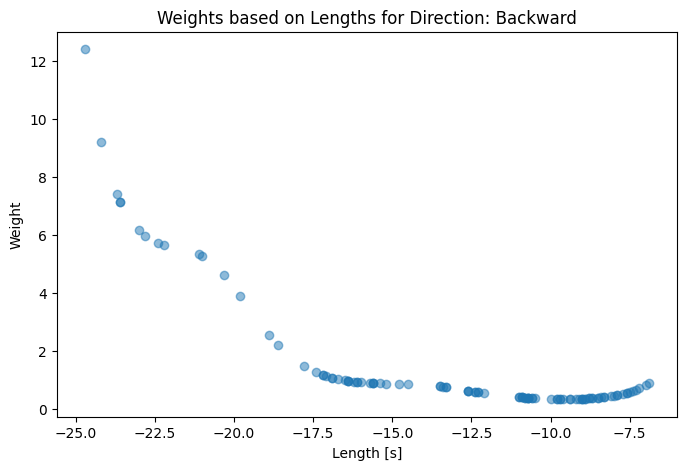

In [10]:
from sklearn.neighbors import KernelDensity
import numpy as np
alpha = 2
# lengths: numpy array of shape (N,)
for direction in ['Forward', 'Backward']:
    dir_labels = all_labels[log_names.loc[all_labels['log_index'], 'direction'] == direction]
    lengths = dir_labels['Length'].values[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(lengths)
    x_d = np.linspace(0, lengths.max(), 1000)[:, np.newaxis]
    log_dens = kde.score_samples(x_d)
    peak_index = np.argmax(log_dens)
    peak_length = x_d[peak_index][0]
    print(f"Direction: {direction}, Peak Length (KDE): {peak_length:.2f} s")
    plt.figure(figsize=(8, 5))
    plt.plot(x_d[:, 0], np.exp(log_dens))
    plt.title(f'KDE of Label Lengths for Direction: {direction}')
    plt.xlabel('Length [s]')
    plt.ylabel('Density')
    plt.show()

    weights = 1 / np.exp(kde.score_samples(lengths))

    weights = weights / np.mean(weights)
    weights = weights ** 2

    plt.figure(figsize=(8, 5))
    plt.scatter(lengths, weights, alpha=0.5)
    plt.title(f'Weights based on Lengths for Direction: {direction}')
    plt.xlabel('Length [s]')
    plt.ylabel('Weight')
    plt.show()

### Label Timeseries

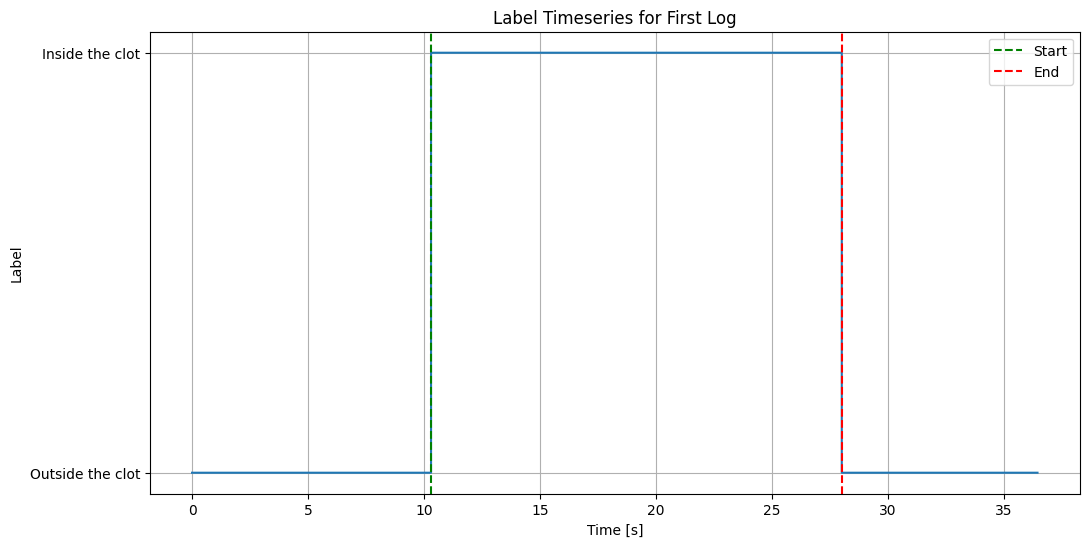

In [11]:
label_timeseries = get_label_timeseries(labels, logs)
# plot the first label timeseries
plt.figure(figsize=(12, 6))
plt.plot(label_timeseries[0]['timestamps'], label_timeseries[0]['in_clot'], drawstyle='steps-post')
# add vertical line at start and end labels 
plt.axvline(x=labels[0]['Start'].values[0], color='g', linestyle='--', label='Start')
plt.axvline(x=labels[0]['End'].values[0], color='r', linestyle='--', label='End')
plt.xlabel('Time [s]')
plt.ylabel('Label')
# make y ticks 0 and 1
plt.yticks([0, 1], ['Outside the clot', 'Inside the clot'])
plt.title('Label Timeseries for First Log')
plt.grid()
plt.legend()
plt.show()

## Preprocessing

In [12]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs_old(logs_fit, data_fit, data_fit_plot)

0it [00:00, ?it/s]

206it [00:01, 147.56it/s]

Preprocessing time: 1.398 s


## Visualize the Data

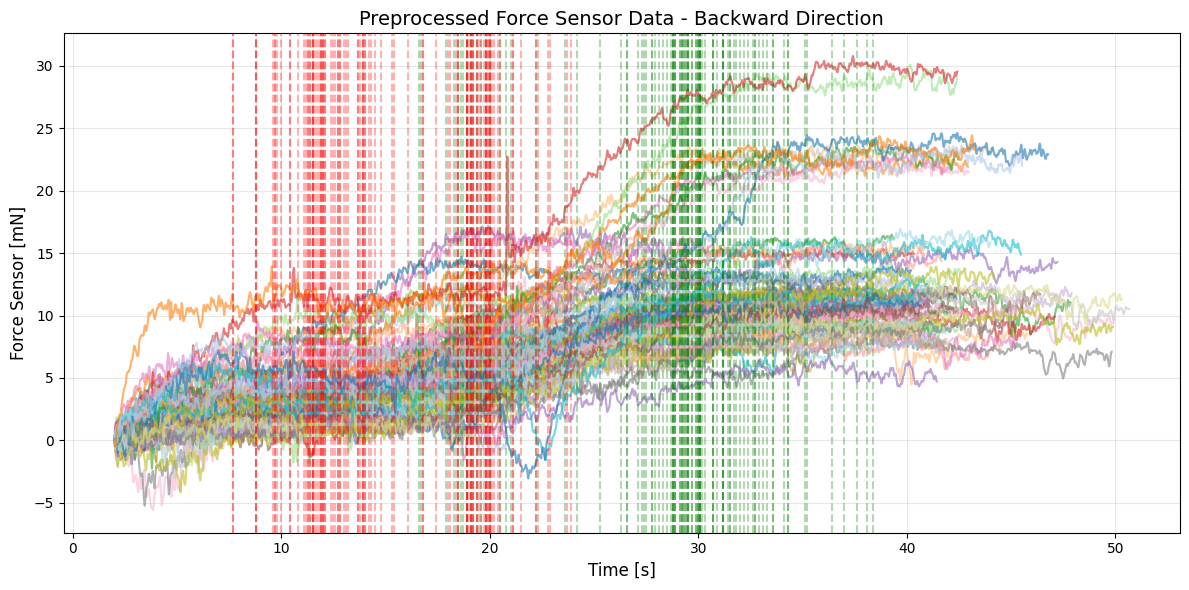

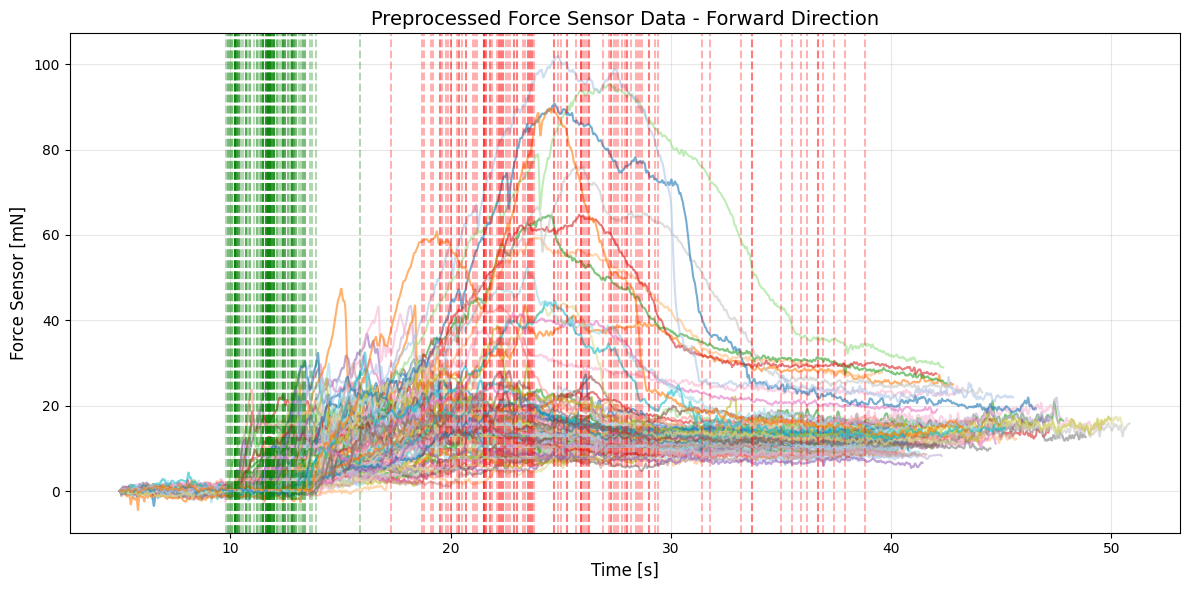

In [13]:
# Combine all curves into a single DataFrame for easier plotting
def plot_signals(data_fit_plot, logs_fit, labels):
    plot_data = []
    for i, df in enumerate(data_fit_plot):
        df_plot = df.copy()
        df_plot['log_index'] = i
        df_plot['direction'] = logs_fit.loc[i, 'direction']
        df_plot['stiffness'] = logs_fit.loc[i, 'stiffness']
        plot_data.append(df_plot)
    plot_df = pd.concat(plot_data, ignore_index=True)


    for direction in ['Backward', 'Forward']:
        plt.figure(figsize=(12, 6))
        # Filter by direction
        dir_df = plot_df[plot_df['direction'] == direction]
        
        # Plot using sns.lineplot with alpha blending
        sns.lineplot(
            data=dir_df,
            x='timestamps',
            y='force_sensor_mN',
            hue='log_index',        # Different color per log
            palette='tab20',        # Color palette
            alpha=0.6,            # Transparency for overlapping curves
            legend=False            # Avoid huge legends
        )
        
        plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
        plt.xlabel('Time [s]', fontsize=12)
        plt.ylabel('Force Sensor [mN]', fontsize=12)
        # plot on the x axis all the start and end times of the labels as vertical lines
        dir_labels = logs_fit[logs_fit['direction'] == direction].index
        for idx in dir_labels:
            start_time = labels[idx]['Start'].values[0]
            end_time = labels[idx]['End'].values[0]
            plt.axvline(x=start_time, color='g', linestyle='--', alpha=0.3)
            plt.axvline(x=end_time, color='r', linestyle='--', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_signals(data_fit_plot, logs_fit, labels)

## Frequency Analysis

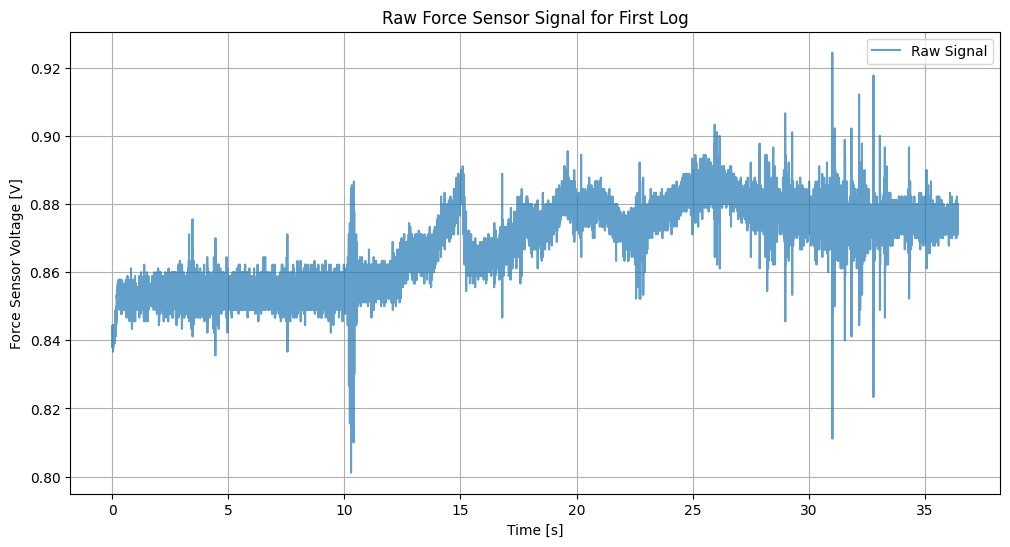

In [14]:
# plot raw signal of first log
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], logs[0]['force_sensor_v'], label='Raw Signal', alpha=0.7)
plt.title('Raw Force Sensor Signal for First Log')
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor Voltage [V]')
plt.grid()
plt.legend()
plt.show()

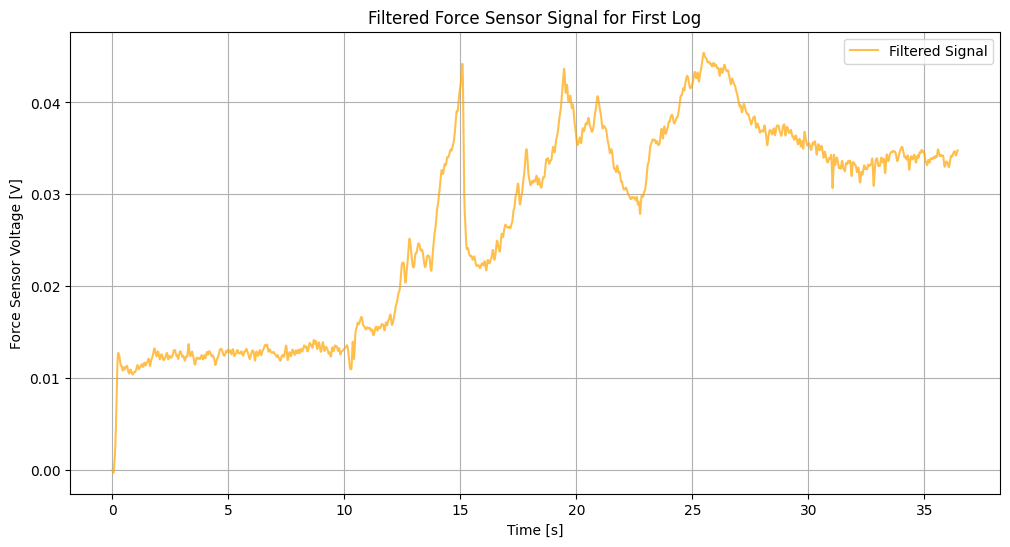

In [15]:
# plot filtered signal of first log
data = logs[0]['force_sensor_v'].values
filtered_log = filter(data, sampling_rate=1000, filter_order=3, cutoff_freq=10)
filtered_log = filtered_log - filtered_log[0]  # Adjust to start from zero
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], filtered_log, label='Filtered Signal', color='orange', alpha=0.7)
plt.title('Filtered Force Sensor Signal for First Log')
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor Voltage [V]')
plt.grid()
plt.legend()
plt.show()

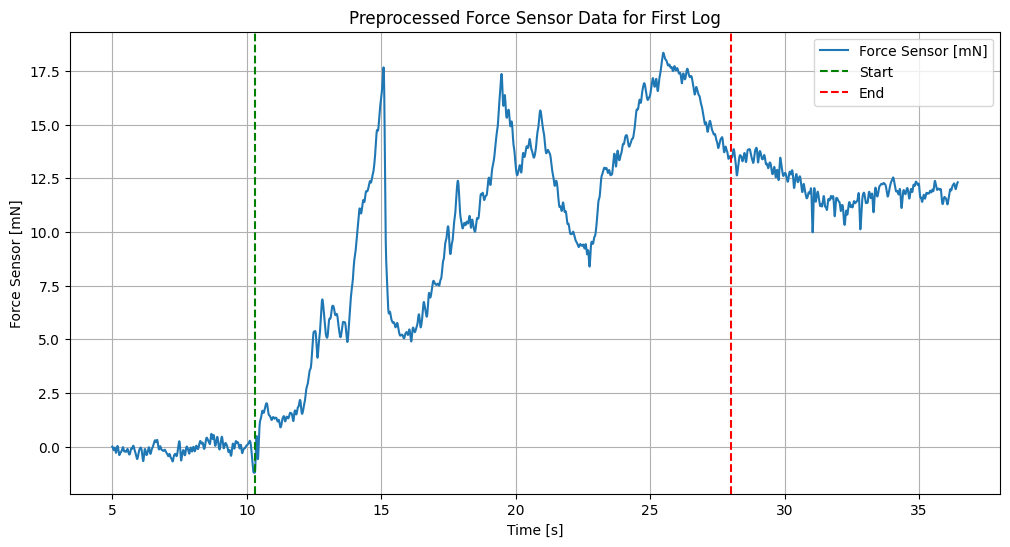

In [16]:
# plot first force curve
for i, df in enumerate(data_fit_plot[:1]):
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamps'], df['force_sensor_mN'], label='Force Sensor [mN]')
    # add vertical line at start and end labels 
    plt.axvline(x=labels[i]['Start'].values[0], color='g', linestyle='--', label='Start')
    plt.axvline(x=labels[i]['End'].values[0], color='r', linestyle='--', label='End')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Sensor [mN]')
    plt.title('Preprocessed Force Sensor Data for First Log')
    plt.grid()
    plt.legend()
    plt.show()

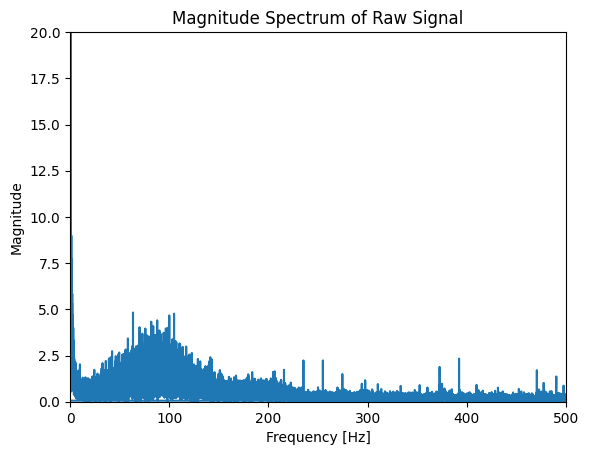

In [17]:
# compute FT of the whole raw signal using scipy.fft
import scipy.fft
data_raw = logs[0]['force_sensor_v'].values
fft_raw = scipy.fft.fft(data_raw)
frequencies_raw = scipy.fft.fftfreq(len(data_raw), d=1/1000)
# plot the magnitude spectrum
plt.plot(frequencies_raw, np.abs(fft_raw))
plt.title('Magnitude Spectrum of Raw Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 500)
plt.ylim(0, 20)
plt.show()

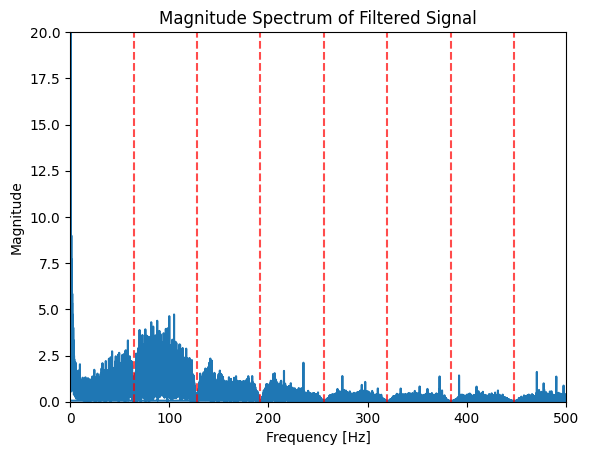

In [18]:
import numpy as np
from scipy.signal import iirnotch, filtfilt
import matplotlib.pyplot as plt
import scipy.fft

fs = 1000        # sampling rate
fundamental = 64 # change to 60 if needed
Q = 30           # quality factor

data = data_raw.copy()

# apply a notch at each harmonic up to Nyquist
for k in range(1, int((fs/2)//fundamental) + 1):
    f0 = fundamental * k
    b, a = iirnotch(f0, Q, fs)
    data = filtfilt(b, a, data)

data_filtered = data

fft_filtered = scipy.fft.fft(data_filtered)
frequencies_filtered = scipy.fft.fftfreq(len(data_filtered), d=1/1000)
# plot the magnitude spectrum
plt.plot(frequencies_filtered, np.abs(fft_filtered))
plt.title('Magnitude Spectrum of Filtered Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 500)
plt.ylim(0, 20)
# plot vline at noise frequencies
for k in range(1, int((fs/2)//fundamental) + 1):
    plt.axvline(fundamental * k, color='r', linestyle='--', alpha=0.7)
plt.show()

- use 500 Hz for bands visua insepction
- Try and use Shapely to find relevat bands
- Baesian opitmization
- Use marker from outside

### Raw signal spectrometry

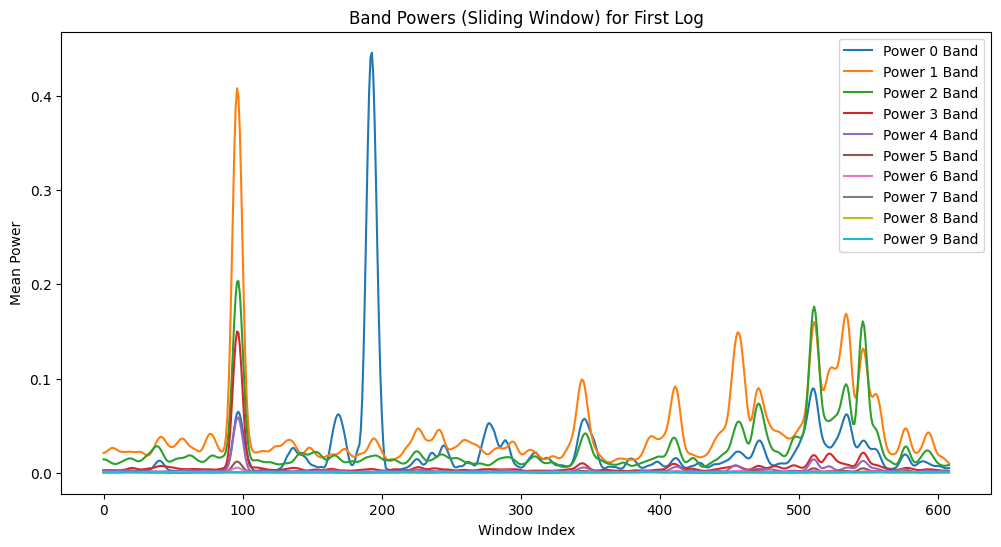

609
609


In [19]:
from scipy.signal import spectrogram
data_raw = logs[0].copy()
first_time = data_fit[0]["timestamps"].iloc[0]
data_raw = data_raw[(data_raw["timestamps"] >= first_time)]
data_raw = data_raw['force_sensor_mN'].values
window_size = 1000 # samples
overlap = 950    # samples
step_size = window_size - overlap
num_windows = (len(data_raw) - overlap) // step_size
n_bands = 10
band_powers_sliding = np.zeros((num_windows, n_bands))  # 10 bands
for w in range(num_windows):
    start_idx = w * step_size
    end_idx = start_idx + window_size
    segment = data_raw[start_idx:end_idx]
    f_seg, t_seg, Sxx_seg = spectrogram(segment, fs=1000, window='hann',
                                       nperseg=window_size, noverlap=overlap, scaling='density')
    power_spectrum = np.mean(Sxx_seg, axis=1)  # Average over time
    freq_bins = np.linspace(0, fs/2, n_bands + 1)
    for b in range(n_bands):
        f_low = freq_bins[b]
        f_high = freq_bins[b + 1]
        idx = np.where((f_seg >= f_low) & (f_seg < f_high))[0]
        if len(idx) == 0:
            band_power = 0
        else:
            band_power = power_spectrum[idx].mean()
        band_powers_sliding[w, b] = band_power
# normalize data_raw 
data_raw_standardized = data_raw - np.mean(data_raw)
data_raw_standardized = data_raw_standardized / np.std(data_raw_standardized)
# get rid of overlap samples at the beginning of data_raw_standardized
data_raw_standardized = data_raw_standardized[overlap:]
plt.figure(figsize=(12, 6))
for b in range(n_bands):
    plt.plot(band_powers_sliding[:, b], label=f'Power {b} Band')
plt.title('Band Powers (Sliding Window) for First Log')
plt.xlabel('Window Index')
plt.ylabel('Mean Power')
plt.legend()
plt.show()
print(len(data_raw_standardized)//50)
print(len(band_powers_sliding[:,0]))

# Extra Data
We're missing markers for Experiments_2024_07_22/anatomical_2mms_360degs
- Experiments_2024_06_26/Twist - 1 translation - 180 rotation/Clot 2/Backward/markers.mat'


## Anatomical

In [20]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = ld.get_anat_logs()
log_names.reset_index(drop=True, inplace=True)
logs = ld.load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from anatomical data.")

Loaded 159 logs from anatomical data.


In [21]:
log_names.head()

,path,path_markers,datetime,clot_index,direction,model,placement,wire_shape,technique,clot_presence,stiffness,pressure
0,/home/boesch/TREX-Semester-Project/data/raw/Ex...,/home/boesch/TREX-Semester-Project/data/raw/Ex...,2022-08-18 12:28:28,1,Forward,Anatomical,Proximal,Straight,No_Twist,With,NaN,NaN
1,/home/boesch/TREX-Semester-Project/data/raw/Ex...,/home/boesch/TREX-Semester-Project/data/raw/Ex...,2022-08-18 12:29:41,1,Backward,Anatomical,Proximal,Straight,No_Twist,With,NaN,NaN
2,/home/boesch/TREX-Semester-Project/data/raw/Ex...,/home/boesch/TREX-Semester-Project/data/raw/Ex...,2022-08-18 13:41:43,2,Forward,Anatomical,Proximal,Straight,No_Twist,With,NaN,NaN
3,/home/boesch/TREX-Semester-Project/data/raw/Ex...,/home/boesch/TREX-Semester-Project/data/raw/Ex...,2022-08-18 13:42:51,2,Backward,Anatomical,Proximal,Straight,No_Twist,With,NaN,NaN
4,/home/boesch/TREX-Semester-Project/data/raw/Ex...,/home/boesch/TREX-Semester-Project/data/raw/Ex...,2022-08-18 13:47:31,3,Forward,Anatomical,Proximal,Straight,No_Twist,With,NaN,NaN


In [22]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 80 logs with direction Backwards and 79 logs with direction Forwards.


In [23]:
print(f"Found {sum(log_names['placement'] == 'Proximal')} proximal logs  and {sum(log_names['placement'] == 'Bifurcation')} bifurcation logs.")

Found 96 proximal logs  and 63 bifurcation logs.


In [24]:
print(f"Found {sum(log_names['wire_shape'] == 'Straight')} straight wire logs  and {sum(log_names['wire_shape'] == 'Bent')} bent wire logs.")

Found 71 straight wire logs  and 88 bent wire logs.


In [25]:
print(f"Found {sum(log_names['technique'] == 'No_Twist')} no twist wire logs  and {sum(log_names['technique'] == 'Twist')} twist wire logs.")

Found 113 no twist wire logs  and 46 twist wire logs.


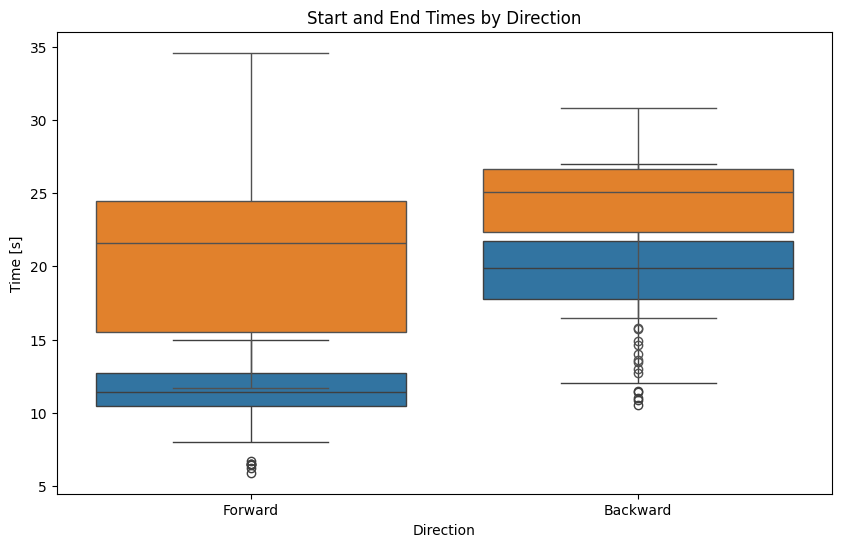

In [26]:
labels = ld.load_labels(log_names)

all_labels = pd.DataFrame()

for i, label in enumerate(labels):
    direction = log_names.loc[i, 'direction']

    # Add direction
    label['Direction'] = direction

    # Original times
    label['Start_orig'] = label['Start']
    label['End_orig'] = label['End']

    # Corrected times based on direction
    if direction == 'Backward':
        label['Start_corr'] = label['End']
        label['End_corr'] = label['Start']
    else:
        label['Start_corr'] = label['Start']
        label['End_corr'] = label['End']

    label['log_index'] = i

    all_labels = pd.concat([all_labels, label], ignore_index=True)

# ----------------------------------------------------
# Plot corrected start/end with direction labeling
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='Direction', y='Start_corr', data=all_labels)
sns.boxplot(x='Direction', y='End_corr', data=all_labels)

plt.title('Start and End Times by Direction')
plt.ylabel('Time [s]')
plt.show()

159it [00:01, 150.79it/s]


Preprocessing time: 1.057 s


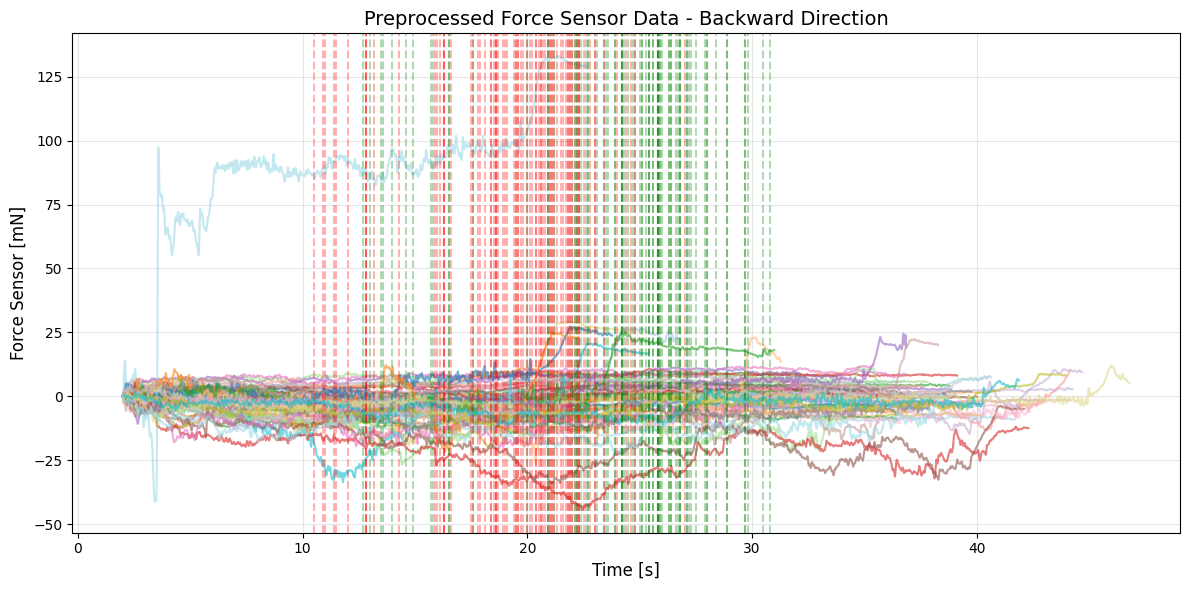

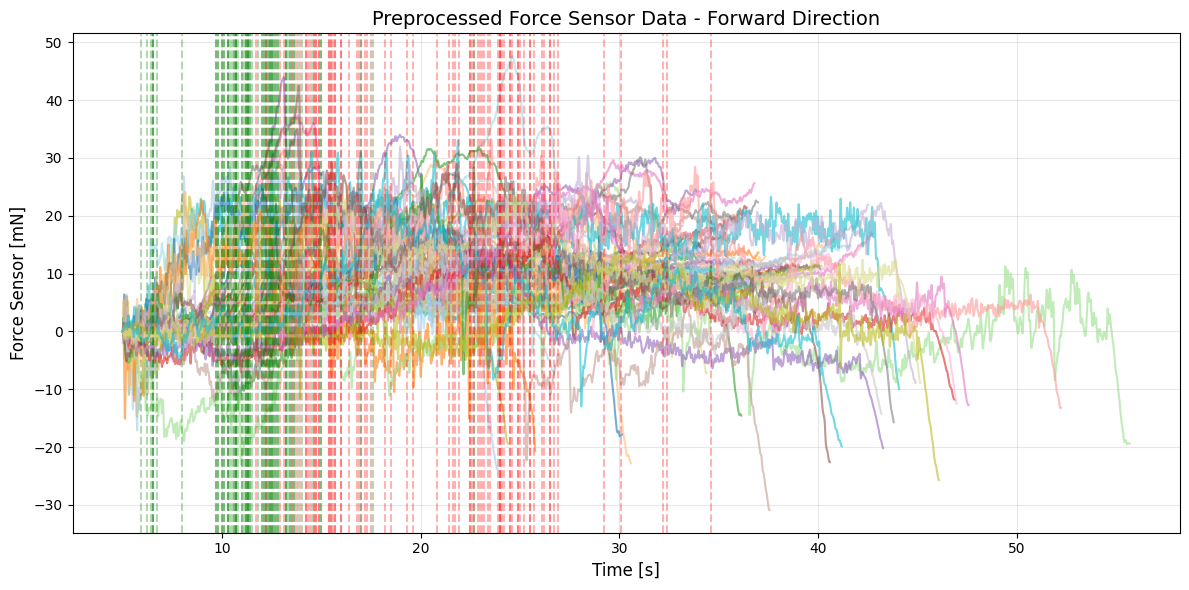

In [27]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs_old(logs_fit, data_fit, data_fit_plot)
plot_signals(data_fit_plot, logs_fit, labels)

## Conical

In [28]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = ld.get_conical_logs()
log_names.reset_index(drop=True, inplace=True)
logs = ld.load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from conical data.")

Loaded 212 logs from conical data.


In [29]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 104 logs with direction Backwards and 108 logs with direction Forwards.


In [30]:
print(f"Found {sum(log_names['placement'] == 'Proximal')} proximal logs  and {sum(log_names['placement'] == 'Bifurcation')} bifurcation logs.")

Found 0 proximal logs  and 0 bifurcation logs.


In [31]:
print(f"Found {sum(log_names['wire_shape'] == 'Straight')} straight wire logs  and {sum(log_names['wire_shape'] == 'Bent')} bent wire logs.")

Found 34 straight wire logs  and 178 bent wire logs.


In [32]:
print(f"Found {sum(log_names['technique'] == 'No_Twist')} no twist wire logs  and {sum(log_names['technique'] == 'Twist')} twist wire logs.")

Found 110 no twist wire logs  and 102 twist wire logs.


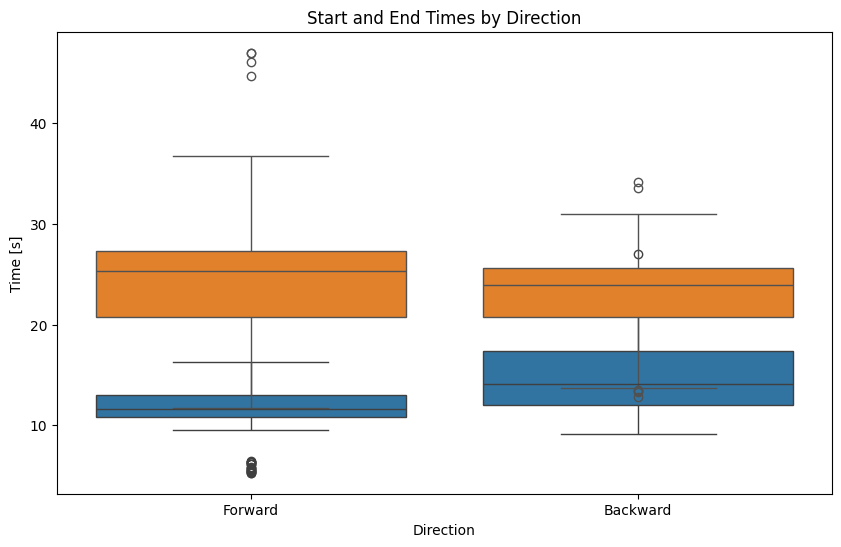

In [33]:
labels = ld.load_labels(log_names)

all_labels = pd.DataFrame()

for i, label in enumerate(labels):
    direction = log_names.loc[i, 'direction']

    # Add direction
    label['Direction'] = direction

    # Original times
    label['Start_orig'] = label['Start']
    label['End_orig'] = label['End']

    # Corrected times based on direction
    if direction == 'Backward':
        label['Start_corr'] = label['End']
        label['End_corr'] = label['Start']
    else:
        label['Start_corr'] = label['Start']
        label['End_corr'] = label['End']

    label['log_index'] = i

    all_labels = pd.concat([all_labels, label], ignore_index=True)

# ----------------------------------------------------
# Plot corrected start/end with direction labeling
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='Direction', y='Start_corr', data=all_labels)
sns.boxplot(x='Direction', y='End_corr', data=all_labels)

plt.title('Start and End Times by Direction')
plt.ylabel('Time [s]')
plt.show()

In [34]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs_old(logs_fit, data_fit, data_fit_plot)

192it [00:03, 26.11it/s] 

212it [00:04, 45.50it/s]

Preprocessing time: 4.661 s


211 211 211


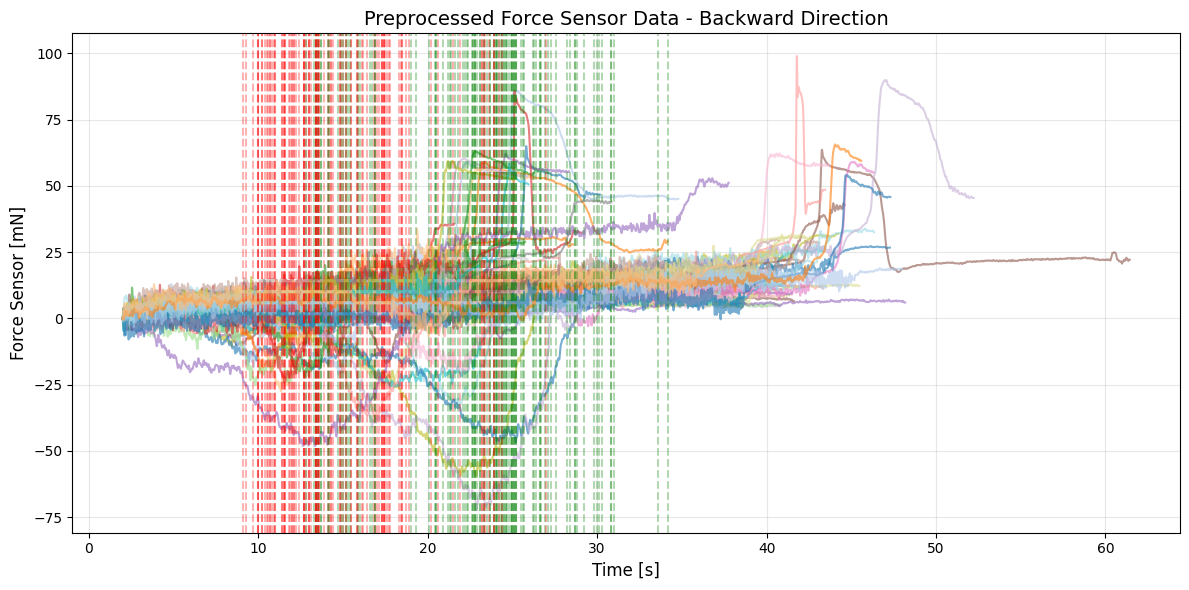

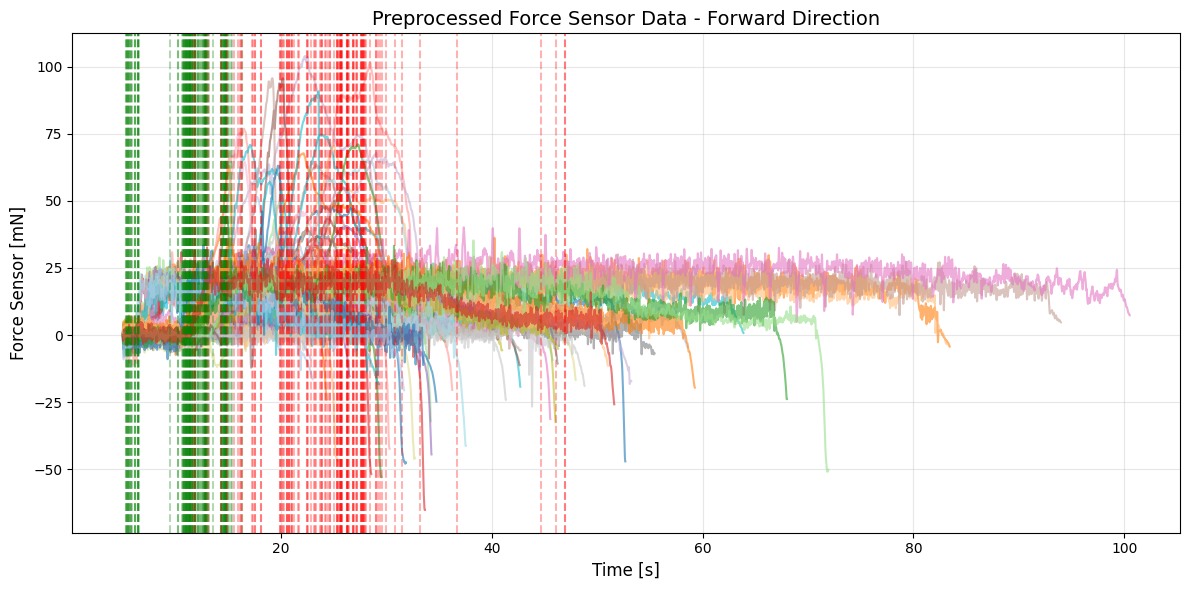

In [ ]:
drop_index = 190
del data_fit_plot[drop_index]
logs_fit = logs_fit.drop(drop_index).reset_index(drop=True)
del labels[drop_index]
plot_signals(data_fit_plot, logs_fit, labels)

# SensorDataset Analysis

In [16]:
from data.sensor_dataset import SensorDataset
paper_dataset = SensorDataset(log_names=ld.get_paper_logs(), with_augmentation=False)
conical_dataset = SensorDataset(log_names=ld.get_conical_logs(), with_augmentation=False)
anatomical_dataset = SensorDataset(log_names=ld.get_anat_logs(), with_augmentation=False)